In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt

In [31]:
def get_adjusted_close(symbol, start="2020-01-01", end="2025-07-25", columns='Close'):
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start, end=end,auto_adjust=False)
    if df.empty:
        print(f"{symbol} 無資料")
        return pd.DataFrame()
    if columns == 'all':
        return df
    elif isinstance(columns, str):
        return df[[columns]]
    else:
        return df[columns]

def get_yfinance_datas(symbols, columns='Close', start_date="2020-01-01", end_date="2025-07-25"):
    #['Open','High','Low','Close','Volume','Dividends','Stock Splits','Split Ratio','Adj Close','adj_factor']
    # symbols 可以是字串或字串list
    if isinstance(symbols, str):
        symbols = [symbols]

    result_df = pd.DataFrame()
    for sym in symbols:
        adj_df = get_adjusted_close(sym, columns=columns, start=start_date, end=end_date)
        # 多檔股票，用 MultiIndex columns 分辨
        adj_df.columns = pd.MultiIndex.from_product([[sym], adj_df.columns])
        if result_df.empty:
            result_df = adj_df
        else:
            result_df = pd.concat([result_df, adj_df], axis=1)
    result_df.columns = result_df.columns.droplevel(1)
    return result_df

In [32]:
data=get_yfinance_datas(symbols=["3211.TWO", "6925.TWO", "3363.TWO", "6223.TWO", "2072.TWO", "00679B.TWO","00883B.TWO" ], columns='Adj Close', start_date="2020-01-01", end_date="2025-09-25")
data.notna().astype(int).mean() # 檢查有無漏資料
###計算收益率
data=data.replace(0, np.nan)###除以零會是無限大or無限小 （inf or -inf）
exp_return=(data.shift(-1)-data)/abs(data)###用abs是怕會有負值
meanReturns = exp_return.mean()
covMatrix = exp_return.cov()

In [33]:
w = 0.6  # 股票總權重 (你可以自由調整，例如 0.6 代表股票佔 60%)
weighting = {}
weighting["3211.TWO"] = w * 0.346536836
weighting["6925.TWO"] = w * 0.09990653
weighting["3363.TWO"] = w * 0.188618227
weighting["6223.TWO"] = w * 0.2037183
weighting["2072.TWO"] = w * 0.16122009
weighting["00883B.TWO"] = 0.2
weighting["00679B.TWO"] = 0.2

# assets = list(weighting.keys())
weights = np.array(list(weighting.values()))

In [34]:
# Monte Carlo Method
mc_sims = 10000 # number of simulations
T = 300 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 1000000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

In [35]:
#抓大盤資料
benchmark=get_yfinance_datas(symbols=['^TWOII'], columns='Adj Close', start_date="2020-01-01", end_date="2025-07-25")
benchmark=benchmark.replace(0, np.nan)###除以零會是無限大or無限小 （inf or -inf）
benchmark=(benchmark.shift(-1)-benchmark)/abs(benchmark)###用abs是怕會有負值
meanReturns_benchmark = benchmark.mean()
covMatrix_benchmark = benchmark.cov()

In [36]:
# Monte Carlo Method(大盤)
mc_sims_b = 10000 # number of simulations
T_b = 300 #timeframe in days

meanM_b = np.full(shape=(T_b, 1), fill_value=meanReturns_benchmark)
meanM_b = meanM_b.T

benchmark_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 1000000

for m in range(0, mc_sims_b):
    # MC loops
    Z = np.random.normal(size=(T, 1))
    L = np.linalg.cholesky(covMatrix_benchmark)
    dailyReturns = meanM_b + np.inner(L, Z)
    benchmark_sims[:,m] = np.cumprod(np.inner(1, dailyReturns.T)+1)*initialPortfolio

In [37]:
# plt.plot(portfolio_sims)
# plt.ylabel('Portfolio Value ($)')
# plt.xlabel('Days')
# plt.title('MC simulation of a stock portfolio')
# plt.show()
     

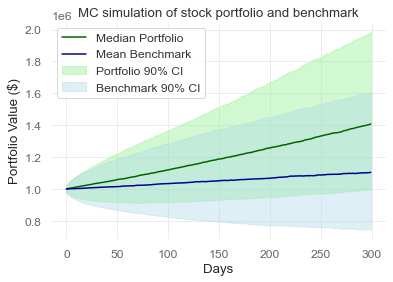

In [ ]:
# portfolio_sims
median_portfolio = np.median(portfolio_sims, axis=1)
lower_bound = np.percentile(portfolio_sims, 5, axis=1)
upper_bound = np.percentile(portfolio_sims, 95, axis=1)

# benchmark_sims
median_benchmark = np.median(benchmark_sims, axis=1)
lower_bound_benchmark = np.percentile(benchmark_sims, 5, axis=1)
upper_bound_benchmark = np.percentile(benchmark_sims, 95, axis=1)

# 畫中位數線
plt.plot(median_portfolio, color='darkgreen', label='Median Portfolio')
plt.plot(median_benchmark, color='darkblue', label='Mean Benchmark')  

# 畫90%信心水準區間
plt.fill_between(range(len(median_portfolio)), lower_bound, upper_bound, color='lightgreen', alpha=0.4, label='Portfolio 90% CI')
plt.fill_between(range(len(median_benchmark)), lower_bound_benchmark, upper_bound_benchmark, color='lightblue', alpha=0.4, label='Benchmark 90% CI')  # 淺藍色

plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of stock portfolio and benchmark')
plt.legend()
plt.show()
